In [10]:
from IMM import IMMEstimator
from kalman_filter import KalmanFilter
from UKF import UnscentedKalmanFilter
import numpy as np
import matplotlib.pyplot as plt
from sigma_points import MerweScaledSigmaPoints

In [11]:
#copied helper functions from filterpy
from numpy import zeros, vstack, eye, array
from scipy.linalg import expm, block_diag

def order_by_derivative(Q, dim, block_size):
    """
    Given a matrix Q, ordered assuming state space
        [x y z x' y' z' x'' y'' z''...]

    return a reordered matrix assuming an ordering of
       [ x x' x'' y y' y'' z z' y'']

    This works for any covariance matrix or state transition function

    Parameters
    ----------
    Q : np.array, square
        The matrix to reorder

    dim : int >= 1

       number of independent state variables. 3 for x, y, z

    block_size : int >= 0
        Size of derivatives. Second derivative would be a block size of 3
        (x, x', x'')


    """

    N = dim * block_size

    D = zeros((N, N))

    Q = array(Q)
    for i, x in enumerate(Q.ravel()):
        f = eye(block_size) * x

        ix, iy = (i // dim) * block_size, (i % dim) * block_size
        D[ix:ix+block_size, iy:iy+block_size] = f

    return D


def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    """
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2, 3, or 4 dt is the time step, and sigma
    is the variance in the noise.

    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity
    model.

    Parameters
    -----------

    dim : int (2, 3, or 4)
        dimension for Q, where the final dimension is (dim x dim)

    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations

    var : float, default=1.0
        variance in the noise

    block_size : int >= 1
        If your state variable contains more than one dimension, such as
        a 3d constant velocity model [x x' y y' z z']^T, then Q must be
        a block diagonal matrix.

    order_by_dim : bool, default=True
        Defines ordering of variables in the state vector. `True` orders
        by keeping all derivatives of each dimensions)

        [x x' x'' y y' y'']

        whereas `False` interleaves the dimensions

        [x y z x' y' z' x'' y'' z'']


    Examples
    --------
    >>> # constant velocity model in a 3D world with a 10 Hz update rate
    >>> Q_discrete_white_noise(2, dt=0.1, var=1., block_size=3)
    array([[0.000025, 0.0005  , 0.      , 0.      , 0.      , 0.      ],
           [0.0005  , 0.01    , 0.      , 0.      , 0.      , 0.      ],
           [0.      , 0.      , 0.000025, 0.0005  , 0.      , 0.      ],
           [0.      , 0.      , 0.0005  , 0.01    , 0.      , 0.      ],
           [0.      , 0.      , 0.      , 0.      , 0.000025, 0.0005  ],
           [0.      , 0.      , 0.      , 0.      , 0.0005  , 0.01    ]])

    References
    ----------

    Bar-Shalom. "Estimation with Applications To Tracking and Navigation".
    John Wiley & Sons, 2001. Page 274.
    """

    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]

    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

## Kalman Filter + IMM

In [12]:

x = np.array([[2.],[0.]])# position   # velocity

F = np.array([[1.,1.], [0.,1.]])
H = np.array([[1.,0.]])
P = np.array([[1000.,    0.], [   0., 1000.] ])
R = np.array([[5.]])
Qvar = 0.13
dt =0.1

def initKalmanFilter(x,F,H,P,R,Qvar, dt):
    dim_x = x.shape[0]
    dim_z = R.shape[0]  
    f = KalmanFilter (dim_x=dim_x, dim_z=dim_z)

    f.x = x = x
    f.F = F
    f.H = H
    f.P = P
    f.R = R

    #from filterpy.common import Q_discrete_white_noise
    f.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=Qvar)

    return f

In [13]:
f1 = initKalmanFilter(x,F,H,P,R,Qvar,dt)
f2 = initKalmanFilter(x,F,H,P,R,Qvar,dt)

filters = [f1, f2]
mu = [0.5, 0.5]  # each filter is equally likely at the start
trans = np.array([[0.97, 0.03], [0.03, 0.97]])
imm = IMMEstimator(filters, mu, trans)

/tmp/ipykernel_53560/1661824718.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xValues[0,i] = imm.x[0]
/tmp/ipykernel_53560/1661824718.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xValues[1,i] = imm.x[1]


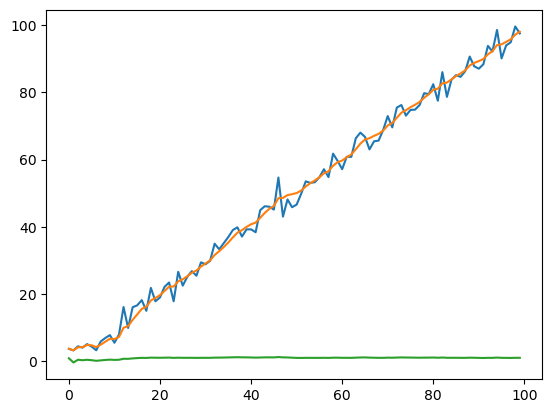

In [14]:
N = 100

zValues =  np.zeros((1,N))
xValues = np.zeros((2,N))

for i in range(N):
    # make some noisy data
    z = i + np.random.randn()*np.sqrt(f1.R[0, 0])
    # y = i + np.random.randn()*np.sqrt(f2.R[1, 1])
    # z = np.array([[x], [y]])

    # perform predict/update cycle
    imm.predict()
    imm.update(z)

    zValues[0,i] = z
    xValues[0,i] = imm.x[0]
    xValues[1,i] = imm.x[1]
    #print(imm.x.T)

# Kalman Filter
# while True:
#     z, R = read_sensor()
#     x, P = predict(x, P, F, Q)
#     x, P = update(x, P, z, R, H)

plt.figure()
plt.plot(zValues[0,:])
plt.plot(xValues[0,:])
plt.plot(xValues[1,:])

## Unscented Kalman Filter + IMM

In [15]:
z_std = 0.1
dt =0.1

x = np.array([-1., 1., -1., 1]) # initial state
P = 0.2 # initial uncertainty
R = np.diag([z_std**2, z_std**2]) # 1 standard
Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01**2, block_size=2)

def fx(x, dt):
    # state transition function - predict next state based
    # on constant velocity model x = vt + x_0
    F = np.array([[1, dt, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, dt],
                    [0, 0, 0, 1]], dtype=float)
    return np.dot(F, x)
    
def hx(x):
    # measurement function - convert state into a measurement
    # where measurements are [x_pos, y_pos]
    return np.array([x[0], x[2]])

# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=-1)

def initUnscentedKalmanFilter(x, fx, hx, points, P, R, Q, dt):
    dim_x = x.shape[0]
    dim_z = R.shape[0]

    kf = UnscentedKalmanFilter(dim_x=dim_x, dim_z=dim_z, dt=dt, fx=fx, hx=hx, points=points)
    #              sqrt_fn=None, x_mean_fn=None, z_mean_fn=None,
    #              residual_x=None,
    #              residual_z=None,
    #              state_add=None)

    kf.x = x
    kf.P *= P 
    kf.R = R 
    kf.Q = Q

    return kf

In [16]:
f1 = initUnscentedKalmanFilter(x, fx, hx, points, P, R, Q, dt)
f2 = initUnscentedKalmanFilter(x, fx, hx, points, P, R, Q, dt)

filters = [f1, f2]
mu = [0.5, 0.5]  # each filter is equally likely at the start
trans = np.array([[0.97, 0.03], [0.03, 0.97]])
immUkf = IMMEstimator(filters, mu, trans)

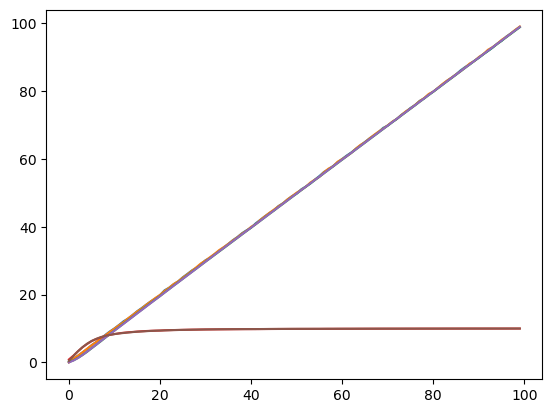

In [20]:
N = 100

#zs = [[i+randn()*z_std, i+randn()*z_std] for i in range(N)]

zValues =  np.zeros((2,N))
xValues = np.zeros((4,N))

for i in range(N):
    # make some noisy data
    z = [i + np.random.randn()*z_std, i + np.random.randn()*z_std]
    # y = i + np.random.randn()*np.sqrt(f2.R[1, 1])
    # z = np.array([[x], [y]])

    # perform predict/update cycle
    immUkf.predict()
    immUkf.update(z)

    zValues[0,i] = z[0]
    zValues[1,i] = z[1]

    xValues[0,i] = immUkf.x[0]
    xValues[1,i] = immUkf.x[1]
    xValues[2,i] = immUkf.x[2]
    xValues[3,i] = immUkf.x[3]
    #print(imm.x.T)

# Kalman Filter
# while True:
#     z, R = read_sensor()
#     x, P = predict(x, P, F, Q)
#     x, P = update(x, P, z, R, H)

plt.figure()
plt.plot(zValues[0,:])
plt.plot(zValues[1,:])
plt.plot(xValues[0,:])
plt.plot(xValues[1,:])
plt.plot(xValues[2,:])
plt.plot(xValues[3,:])